# Applied Data Science Capstone: a Comparison Between Financial Centres
This notebook contains the exercises, information and scripts of the *Applied Data Science Capstone Project*.

## Important Links
1. Git management: https://medium.com/@aklson_DS/how-to-properly-setup-your-github-repository-windows-version-ea596b398b

## Business Problem
Thanks to globalization and the evolution of communication technologies the financial markets are very interconected. This opens the posibility for financiers around the world to search new cities to live in, according to the characteristics and facilities of each city, and without the cost of losing access to the markets. 

There are many factors to consider before settling down in a new country/city. Considering the the socio-economic shock that is SARS-CoV-2 around the globe, the readines of a country to face a pandemic is crucial. This is why the Global Helath Security Index is a key characteristic to determine which city is going to be your new home.

Other factor to consider is the population of the city, which is a proxy value for the size of the city and could be an indicator of how hectic each city is. 

Another important characteristic is the types of venues found in each city. That is why in this exercise I will compare the top 50 financial centres of the world according to their types of venues, to determine the different types of financial centres cities. 

With this three factors evaluated, this exercise clusters the top 50 financial centres around the world, showing which sets of cities are similar, making easier the decision of moving. 

## Data
The data that will be used for this proyect is:
1. The ranking of the top financial centres cities ranked according to the Global Financial Centres Index. This databas shows the first 108 cities ranked according to the index as of March 26, 2020. This data can be found in: https://en.wikipedia.org/wiki/Global_Financial_Centres_Index
2. The database of cities and coordinates. This database contains a list of 15.493 cities of all countries around the world, with its host country and its coordinates. This data can be found in: https://simplemaps.com/data/world-cities
3. The data base with the Global Health Security Index (GHS index). This document contains various charts and tables, in which there are 34 indicators divided in 6 categories for 195 countries, which are combined in the Global Health Security Index. This index combines the scores in the country's prevention, detection and respond capabilities, plus the score of its health system, norms and risk. This information can be found in: https://www.ghsindex.org/about/
3. The API of foursquare for determine the most frequent types of venues found in each city. Information of this API can be accessed in: https://foursquare.com/


## Methodology
The firt step is to import all the libraries that will be used in this project:

In [65]:
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import json
import requests
mpl.style.use("ggplot")

### Web Scraping
The first step is to access the dataseto of the top financial centres according to the Global Financial Centres Index, which is in Wikipedia:

In [2]:
url =  "https://en.wikipedia.org/wiki/Global_Financial_Centres_Index"
df = pd.read_html(url, header = 0)
len(df)

7

Checking the first 5 cities in the list of top financial centres:

In [3]:
#df[1]
df_top20 = df[1]
df_top20 = df_top20.loc[:,["Centre","Rating"]]
df_top20.replace("New York City", "New York",inplace=True)
df_top20.head()

,Centre,Rating
0,New York,769
1,London,742
2,Tokyo,741
3,Shanghai,740
4,Singapore,738


### Data Wrangling
With the first dataset in place, the next step is to access the dataset with the coordinates. One key detail is verifing that the city names in the top financial centres (TOP DF) are the same in this dataset. For example, Tel Aviv and Washington have different names, so I standarize this:

In [4]:
df_crd = pd.read_excel("worldcities.xlsx")
df_crd.replace(["Tel Aviv-Yafo","Washington"],["Tel Aviv","Washington, D.C."], inplace = True)
df_crd.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


In [5]:
df_crd.columns

Index(['city', 'city_ascii', 'lat', 'lng', 'country', 'iso2', 'iso3',
       'admin_name', 'capital', 'population', 'id'],
      dtype='object')

In this step I select the variables of interest in this dataset for the project:

In [6]:
df_crd = df_crd.loc(axis=1)["city_ascii","lat","lng","population","country"]
df_crd.head()

,city_ascii,lat,lng,population,country
0,Tokyo,35.6850,139.7514,35676000.0,Japan
1,New York,40.6943,-73.9249,19354922.0,United States
2,Mexico City,19.4424,-99.1310,19028000.0,Mexico
3,Mumbai,19.0170,72.8570,18978000.0,India
4,Sao Paulo,-23.5587,-46.6250,18845000.0,Brazil


In this script I merge the TOP DF dataframe with the coordinates dataframe. One key variable is the countries where the cities are, because the GHS index was made for each country:

In [7]:
df_1 = pd.merge(left=df_top20, right=df_crd, how="left", left_on="Centre",right_on="city_ascii")
df_1.sort_values(["Rating","population"],ascending=False, inplace=True)
cnames = ["City","Rating","Population","Latitude","Longitude"]
df_cit = pd.DataFrame(columns=cnames)
for c,r,lt,lg,p,count in zip(df_1["Centre"],df_1["Rating"],df_1["lat"],df_1["lng"],df_1["population"], df_1["country"]):
    if c not in list(df_cit["City"]):
        df_cit = df_cit.append({"City":c,
                        "Rating":r,
                        "Population":p,
                        "Latitude":lt,
                        "Longitude":lg,
                               "Country":count}, ignore_index=True)
    else:
        continue
print(df_cit.shape)
df_cit.dropna(inplace=True)
df_cit.reset_index(inplace=True,drop=True)
df_cit.replace(["Korea, South","Czechia","United States"],["South Korea","Czech Republic","United States of America"], inplace=True)
print(df_cit.shape)
df_cit.head()

(54, 6)
(51, 6)


,City,Rating,Population,Latitude,Longitude,Country
0,New York,769,19354922.0,40.6943,-73.9249,United States of America
1,London,742,8567000.0,51.5000,-0.1167,United Kingdom
2,Tokyo,741,35676000.0,35.6850,139.7514,Japan
3,Shanghai,740,14987000.0,31.2165,121.4365,China
4,Singapore,738,5183700.0,1.2930,103.8558,Singapore


Next, I make a list of the countries in the json file that will be the input for the maps. I stadanrize the names of the countries that appear in both datasets:

In [8]:
world_geo='world_countries.json'
data = open(world_geo)
js = json.load(data)
#print(js)
countries_json = list()
for dic in js["features"]:
    countries_json.append(dic["properties"]["name"])
#js["features"][0]["properties"]["name"]
#print(sorted(countries_json))


In [45]:
df_prep = pd.read_excel("v.xlsx", header=None)
headers = ["drop","Country","Score"]
a=["United States","Congo (Democratic Republic)", "Côte d'Ivoire","Congo (Brazzaville)","Marshall Islands","Kyrgyz Republic","North Macedonia","Serbia","Tanzania"]
b=["United States of America","Democratic Republic of the Congo","Ivory Coast","Republic of the Congo","Falkland Islands","Kyrgyzstan","Macedonia","Republic of Serbia","United Republic of Tanzania"]
df_prep.columns = headers
df_prep.drop("drop",axis=1,inplace=True)
df_prep.sort_values("Country",ascending=True,inplace=True)
#df_prep.rename(["United States"],["United States of America"])
df_prep.replace(a,b,inplace=True)
print(df_prep["Score"].mean())
df_prep.head()

#for i in df_prep["Country"]:
    #print(i, i in countries_json)

40.19999999999999


,Country,Score
129,Afghanistan,32.3
38,Albania,52.9
172,Algeria,23.6
142,Andorra,30.5
169,Angola,25.2


In [10]:
a = list(df_cit["Country"].unique())
b = list(df_prep["Country"])
#print(b)
for i in countries_json:
    if i not in b:
        print(i)

Antarctica
French Southern and Antarctic Lands
The Bahamas
Northern Cyprus
Guinea Bissau
Greenland
Kosovo
New Caledonia
Puerto Rico
Western Sahara
Somaliland
Swaziland
East Timor
Taiwan
West Bank


In [11]:
a = list(df_cit["Country"].unique())
b = list(df_prep["Country"])
#print(b)
for i in b:
    if i not in countries_json:
        print(i)

Andorra
Antigua and Barbuda
Bahamas
Bahrain
Barbados
Cabo Verde
Comoros
Cook Islands
Dominica
Grenada
Guinea-Bissau
Kiribati
Liechtenstein
Maldives
Malta
Mauritius
Micronesia
Monaco
Nauru
Niue
Palau
Samoa
San Marino
Seychelles
Singapore
St Kitts and Nevis
St Lucia
St Vincent and The Grenadines
São Tomé and Príncipe
Timor-Leste
Tonga
Tuvalu
eSwatini (Swaziland)


In this map I use the GHS index for the choropleth map, and add the location of top 50 financial centres:

In [12]:
world_map = folium.Map(location = [0,0], zoom_start = 1)

threshold_scale = np.linspace(df_prep["Score"].min(),
                             df_prep["Score"].max(),
                             6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1

cols = ['pink', 'cadetblue', 'darkred', 'black', 'darkblue', 'blue', 'white', 'purple', 'lightgray', 'darkpurple', 'gray', 'lightblue', 'lightgreen', 'red', 'orange', 'green', 'beige', 'lightred', 'darkgreen']
for lt, lg, c,p,r in zip(df_cit.Latitude, df_cit.Longitude, df_cit.City, df_cit.Population, df_cit.Rating):
    label = "{}, Population:{}, Rating: {}".format(c,format(int(p),","),r)
    folium.Marker(
        location=[lt,lg],
        popup=label,
        icon=folium.Icon(color = cols[np.random.randint(0,19)], icon = "usdd") ,
        ).add_to(world_map)
    
folium.Choropleth(
    geo_data=world_geo,
    data=df_prep,
    columns=["Country","Score"],
    key_on="feature.properties.name",
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Global Health Security Score',
    reset=True
).add_to(world_map)

world_map

In [22]:
CLIENT_ID = 'WBOVFFRVZAVZURLH1AG5LHJUYCPTVQYEZDWOH5S231KZKERY' # your Foursquare ID
CLIENT_SECRET = 'KX5HIRWTCSQGWYF1Q4P2FXMQFXSF1ABWPVGNQETQAPMG0HQ1' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version

Next I use the foursquare API to make a list of the venues of each city:

In [28]:
def getNearbyVenues(names, country, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name,country, lat, lng in zip(names, country, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try: results = requests.get(url).json()["response"]['groups'][0]['items']
        except: continue
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            country,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                             "Country",
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
LIMIT = 50000
geolocator = Nominatim(user_agent="c_explorer")
cities_venues = getNearbyVenues(names=df_cit["City"],
                                country=df_cit["Country"],
                               latitudes=df_cit["Latitude"],
                               longitudes=df_cit["Longitude"])

In this table shows the first 5 (of the 5100 results) venues found:

In [82]:
print(cities_venues.shape)
cities_venues[["City","Country","Venue","Venue Latitude","Venue Longitude", "Venue Category"]].head(20)


(5100, 8)


,City,Country,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,United States of America,Carmenta’s,40.701320,-73.926783,Italian Restaurant
1,New York,United States of America,Henry's Wine and Spirit,40.701051,-73.930253,Wine Shop
2,New York,United States of America,Taqueria Al Pastor,40.703307,-73.918069,Taco Place
3,New York,United States of America,Arepera Guacuco Restaurant,40.704775,-73.924500,Arepa Restaurant
4,New York,United States of America,Local Honey,40.704902,-73.924325,Nail Salon
5,New York,United States of America,Kings County Brewers Collective,40.705974,-73.923487,Brewery
6,New York,United States of America,Syndicated,40.704882,-73.932992,Indie Movie Theater
7,New York,United States of America,Roberta's Take Out & Bakery,40.704922,-73.934025,Pizza Place
8,New York,United States of America,Roberta's Pizza,40.705015,-73.933617,Pizza Place
9,New York,United States of America,House of Yes,40.706777,-73.923704,Nightclub


This table counts the number of venues per location:

In [31]:
cities_venues.groupby("City").count()

,Country,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,,
Abu Dhabi,100,100,100,100,100,100,100
Amsterdam,100,100,100,100,100,100,100
Beijing,100,100,100,100,100,100,100
Boston,100,100,100,100,100,100,100
Brussels,100,100,100,100,100,100,100
Busan,100,100,100,100,100,100,100
Calgary,100,100,100,100,100,100,100
Casablanca,100,100,100,100,100,100,100
Chicago,100,100,100,100,100,100,100


The number of different types of venues is 373.

In [32]:
len(cities_venues["Venue Category"].unique())

373

This is a frequency table of the different type of venues for each city:

In [33]:
cities_oh = pd.get_dummies(cities_venues[["Venue Category"]], prefix="", prefix_sep="")
list_names= ["City","Country"]+list(cities_oh.columns)
cities_oh["City"] = cities_venues["City"]
cities_oh["Country"] = cities_venues["Country"]
#fixed_columns = [cities_oh.columns[-1]] + list(cities_oh.columns[:-1])
cities_oh = cities_oh[list_names]
cities_oh.head()

,City,Country,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,...,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,New York,United States of America,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,United States of America,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,New York,United States of America,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,United States of America,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,United States of America,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
cities_oh.shape

(5100, 375)

In [84]:
cities_g = cities_oh.groupby("City").mean().reset_index()
print(cities_g.shape)
#df_1 = pd.merge(left=df_top20, right=df_crd, how="left", left_on="Centre",right_on="city_ascii")
cities_g = pd.merge(left=cities_g, right=df_cit[["City","Country","Population"]], left_on="City",right_on="City")
print(cities_g.shape)
cities_g = pd.merge(left=cities_g, right=df_prep, left_on="Country", right_on="Country")
print(cities_g.shape)
print(cities_g["Score"].mean())
cities_g.head()

(51, 374)
(51, 376)
(50, 377)
63.965999999999994


,City,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,...,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Country,Population,Score
0,Abu Dhabi,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,United Arab Emirates,603492.0,46.7
1,Dubai,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,United Arab Emirates,1379000.0,46.7
2,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,0.0,0.03,0.0,0.00,0.00,0.01,Netherlands,1031000.0,75.6
3,Beijing,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,...,0.01,0.0,0.00,0.0,0.02,0.01,0.00,China,11106000.0,48.2
4,Guangzhou,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,China,8829000.0,48.2


C:\Users\ALEJANDRO\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


dtype('float64')

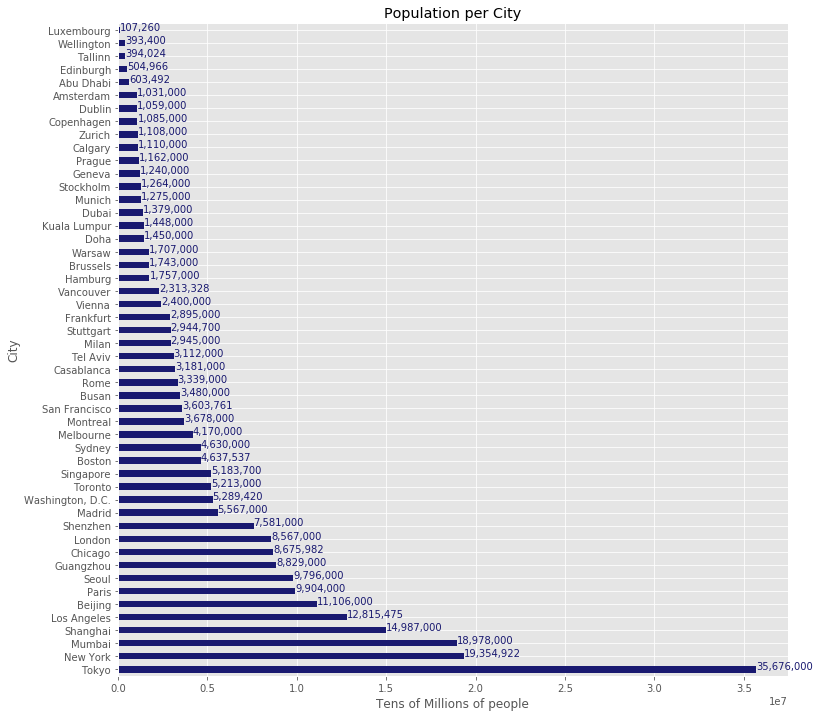

In [85]:
g1 = cities_g[["City","Population"]]
g1.set_index("City", inplace=True)
g1.sort_values(["Population"], ascending=False,axis=0,inplace=True)
g1=g1["Population"]
g1.plot(kind="barh",figsize=(12,12), color = "midnightblue")
plt.title("Population per City")
plt.xlabel("Tens of Millions of people")

for index,value in enumerate(g1):
    label = format(int(value),",")
    plt.annotate(label, xy=(value,index), color= "midnightblue")
g1.dtypes

dtype('int64')

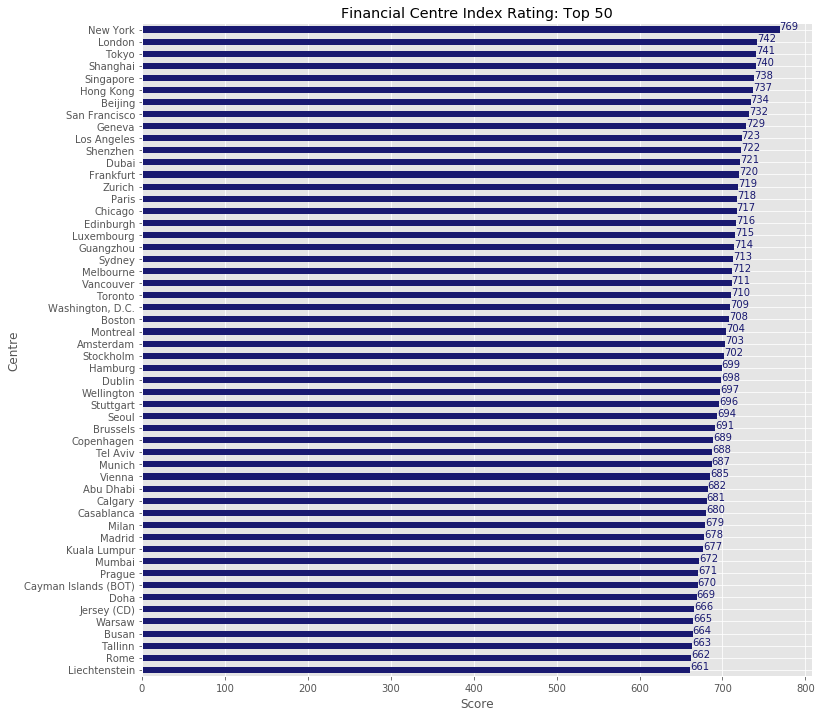

In [86]:
g2 = df_top20.set_index("Centre")
g2.sort_values(["Rating"], ascending=True,axis=0,inplace=True)
g2=g2["Rating"]
g2.plot(kind="barh",figsize=(12,12), color = "midnightblue")
plt.title("Financial Centre Index Rating: Top 50")
plt.xlabel("Score")

for index,value in enumerate(g2):
    label = format(int(value),",")
    plt.annotate(label, xy=(value,index), color= "midnightblue")
g2.dtypes

In this sripct I normalize the score of the GHS index and the population of the city:

In [87]:
cities_g["Score"]= cities_g["Score"]/100
cities_g["Population"]=(cities_g["Population"]-cities_g["Population"].min())/(cities_g["Population"].max()-cities_g["Population"].min())
cities_g.drop("Country",axis=1,inplace=True)
print(cities_g.shape)
cities_g.head()

(50, 376)


,City,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,...,Women's Store,Xinjiang Restaurant,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Population,Score
0,Abu Dhabi,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.013951,0.467
1,Dubai,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.035754,0.467
2,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.03,0.0,0.00,0.00,0.01,0.025971,0.756
3,Beijing,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,0.0,...,0.0,0.01,0.0,0.00,0.0,0.02,0.01,0.00,0.309225,0.482
4,Guangzhou,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.245208,0.482


Here I use the K-means algorithm to cluster the cities according to their characteristics described in the previous table:

In [88]:
kclusters = 5

cities_clustering = cities_g.drop("City",1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_clustering)
len(kmeans.labels_[:])

50

In [89]:
cities_g.insert(0,"Cluster Labels",kmeans.labels_)
cities_g = pd.merge(left=cities_g, right=df_cit[["City","Latitude","Longitude"]], left_on="City",right_on="City")
cities_g.head()

,Cluster Labels,City,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,...,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant,Zoo,Population,Score,Latitude,Longitude
0,2,Abu Dhabi,0.0,0.0,0.0,0.0,0.01,0.0,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.00,0.013951,0.467,24.4667,54.3666
1,2,Dubai,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,...,0.0,0.00,0.0,0.00,0.00,0.00,0.035754,0.467,25.2300,55.2800
2,0,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.03,0.0,0.00,0.00,0.01,0.025971,0.756,52.3500,4.9166
3,1,Beijing,0.0,0.0,0.0,0.0,0.00,0.0,0.01,0.0,...,0.0,0.00,0.0,0.02,0.01,0.00,0.309225,0.482,39.9289,116.3883
4,1,Guangzhou,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,...,0.0,0.00,0.0,0.00,0.00,0.00,0.245208,0.482,23.1450,113.3250


Here I make a map with the 5 different clusters represented with different colors, and a choropleth layer showing the GHS index score:

In [93]:
map_clusters = folium.Map(loction=[0,0], zoom_start=1)

x=np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
folium.Choropleth(
    geo_data=world_geo,
    data=df_prep,
    columns=["Country","Score"],
    key_on="feature.properties.name",
    threshold_scale=threshold_scale,
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Global Health Security Score',
    reset=True
).add_to(map_clusters)
for lat, lon, poi, cluster in zip(cities_g['Latitude'], cities_g['Longitude'], cities_g['City'], cities_g['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Finally I make 5 lists that contain the cities in each cluster:

#### *Cluster 1* 

In [40]:
cities_g.loc[cities_g["Cluster Labels"]==0][["City"]].reset_index(drop=True)

,City
0,Amsterdam
1,Boston
2,San Francisco
3,"Washington, D.C."
4,Busan
5,Calgary
6,Montreal
7,Toronto
8,Vancouver
9,Copenhagen


#### *Cluster 2*

In [41]:
cities_g.loc[cities_g["Cluster Labels"]==1][["City"]].reset_index(drop=True)

,City
0,Beijing
1,Guangzhou
2,Shanghai
3,Shenzhen
4,Mumbai


#### *Cluster3*

In [42]:
cities_g.loc[cities_g["Cluster Labels"]==2][["City"]].reset_index(drop=True)

,City
0,Abu Dhabi
1,Dubai
2,Brussels
3,Casablanca
4,Doha
5,Dublin
6,Kuala Lumpur
7,Luxembourg
8,Milan
9,Rome


#### *Cluster 4*

In [43]:
cities_g.loc[cities_g["Cluster Labels"]==3][["City"]].reset_index(drop=True)

,City
0,Tokyo


#### *Cluster 5*

In [44]:
cities_g.loc[cities_g["Cluster Labels"]==4][["City"]].reset_index(drop=True)

,City
0,Chicago
1,Los Angeles
2,New York
3,Seoul
4,London
5,Paris


#### Results and discussion
Eventhough the top financial centres are in better ranked countires according to the GHS index (the mean of these cities is almost 20 points higher than the mean of all the world), there is enough variation among them (that also is related to develped/developing status) to be a key characteristic to cluster the cities. 

As seen in the last map, a key factor to differenciate the cities is the GHS index (this can be clearly represented in the cluster 3, where most of the lowest rating coutries/cities are clustered). The lower rated cities tend to be in the same cluster. The different venue categories result also important as a differentiating factor among the European cities and South-East Asia cities. The huge population of Tokyo set it appart from the rest of the cities, having its own cluster. 

Among developed nations, where the GHS index is higher, the differentiating factors are venue categories and population. 

Other considerations to dive deeper in this analysis could be: per capita income of the different cities, living costs, mobility indexes, taxes paid, gobernment trust polls results. This traits can generate a better clusters for future work. 